In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from  matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import seaborn as sn
import sys
import os
from pathlib import Path
from tqdm import tqdm
from timeit import default_timer as timer
from datetime import timedelta

import torch.nn as nn
from torch import Tensor
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from torchmetrics.classification import BinaryCalibrationError

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve

from scipy.stats import wasserstein_distance
from sklearn.metrics import roc_auc_score as roc_auc_score
from scipy.special import kl_div as kl_div
from sklearn.metrics import log_loss as log_loss

# import custom functions from src folder
module_path = str(Path.cwd() / "../../../src")

if module_path not in sys.path:
    sys.path.append(module_path)

from SequentialNet import SequentialNet
from machine_learning import *
from util import *


In [2]:
sn.set_palette("tab10")
sn.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [3]:
def word_to_int(df):
    # Red = 0, blue = 1
    df["class"] = 0
    df_copy = df.copy()
    mask = df_copy["color"] == "blue"
    df.loc[mask, "class"] = 1
    return df

def label_maker(values, num_classes):
    labels = np.zeros((len(values), num_classes))
    for i, value in enumerate(values):
        labels[i][value] = 1
    return torch.Tensor(labels).to(torch.int)

In [4]:
def predict_grid(model, x1_key, x2_key, device, nx:int = 100):
    x1_lim = 25
    x2_lim = 25
    x1 = np.linspace(-x1_lim, x1_lim, nx)
    x2 = np.linspace(-x2_lim, x2_lim, nx)
    xx1, xx2 = np.meshgrid(x1, x2)
    df = pd.DataFrame(columns = ["x1", "x2"], index = range(len(xx1.flatten())))
    df["x1"] = xx1.flatten()
    df["x2"] = xx2.flatten()
    df = cartesian_to_polar_df(df, "x1", "x2", "r_x", "a_x")

    X_gridtest = torch.Tensor(np.dstack((df[x1_key], df[x2_key]))).to(torch.float32)[0]
    Y_gridtest = torch.zeros(X_gridtest.shape)
    gridtest_dataset = torch.utils.data.TensorDataset(X_gridtest, Y_gridtest)

    truth, logits = predict_classifier(model, gridtest_dataset, 2, 100, device)
    preds = torch.argmax(logits, dim=-1).flatten()
    df["Prediction"] = preds
    df["Truth"] = truth
    #Get softmax score for blue
    df["Confidence"] = torch.softmax(logits, dim=-1)[:,1]
    return df

In [5]:
# Set up device
device = (
    "cuda:1"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device {torch.cuda.get_device_name(1)}")

Using cuda:1 device NVIDIA TITAN V


In [6]:
# Machine learning options
x1_key = "x1"
x2_key = "x2"
n_data = [250, 500, 1000, 2000, 3000, 5000, 10000]
#n_data = [10000]
max_err_val = [0]*len(n_data)
for i in range(len(n_data)):
    if n_data[i] < 1000:
        max_err_val[i] = 0.5
    else:
        max_err_val[i] = 0.25
patience = 70
load_ensemble_values = False
save_values = True
#Data constants
R2 = 3
k_red = 7
k_blue = 3
R1_min = 6
scale = 1
vary_a1 = False
vary_R2 = False
p_red = 0.5
polar = False
tag = f'r2_{R2}_kr{k_red}_kb{k_blue}_r1min{R1_min}_s{scale}_vary_r2_{vary_R2}_vary_a1_{vary_a1}_pRed_{p_red}'

# Read files
train_n = 50000
trainfile = f"train_n_{train_n}_{tag}"
valfile = f"val_n_5000_{tag}"
testfile = f"test_n_10000_{tag}"
truthfile = f"analytical_solution_x1_x2_grid_{tag}_nr1MC_4000"
truthfile_test = "analytical_solution_test_n_10000_r2_3_kr7_kb3_r1min6_s1_vary_r2_False_vary_a1_False_pRed_0.5_nr1MC_8000"
gridfile = f"x1_x2_grid"

train_data = pd.read_csv(f"../data/{trainfile}.csv")
val_data = pd.read_csv(f"../data/{valfile}.csv")
test_data = pd.read_csv(f"../data/{testfile}.csv")
truth_data = pd.read_csv(f"../analytical/results/{truthfile}.csv")
truth_data = truth_data[truth_data["r_x"] > R1_min-R2] # Remove undefined area
truth_test_data = pd.read_csv(f"../analytical/results/{truthfile_test}.csv")
grid_data = pd.read_csv(f"../data/{gridfile}.csv")

#Correct analytical solution if class distribution is not equal
if p_red != 0.5:
    truth_data["P_red_and_x"] = truth_data["P_red_and_x"]*(p_red)/0.5
    truth_data["P_blue_and_x"] = truth_data["P_blue_and_x"]*(1-p_red)/0.5
    truth_data["P_x"] = truth_data["P_red_and_x"] + truth_data["P_blue_and_x"]
    truth_data["P_red_given_x"] = truth_data["P_red_and_x"]/truth_data["P_x"]
    truth_data["P_blue_given_x"] = truth_data["P_blue_and_x"]/truth_data["P_x"]

# Prepare data for pytorch
train_data = word_to_int(train_data)
val_data = word_to_int(val_data)
test_data = word_to_int(test_data)

X_train = torch.Tensor(np.dstack((train_data[x1_key], train_data[x2_key]))).to(torch.float32)[0]
Y_train = label_maker(train_data["class"], 2)

X_val = torch.Tensor(np.dstack((val_data[x1_key], val_data[x2_key]))).to(torch.float32)[0]
Y_val = label_maker(val_data["class"], 2)

X_test = torch.Tensor(np.dstack((test_data[x1_key], test_data[x2_key]))).to(torch.float32)[0]
Y_test = torch.zeros(X_test.shape)

In [7]:
# Create datasets for pytorch
train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, Y_val)
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)

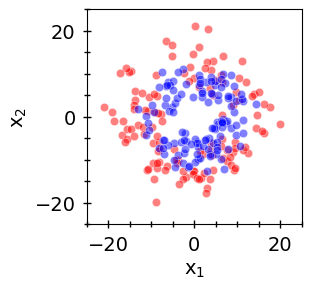

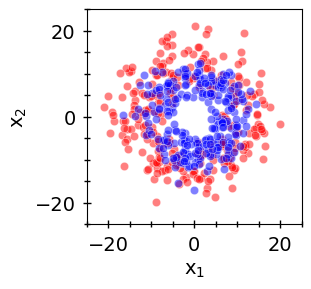

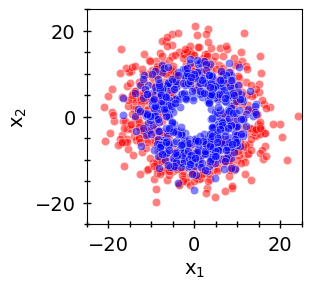

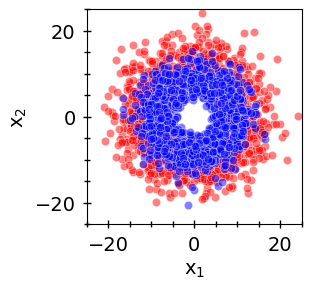

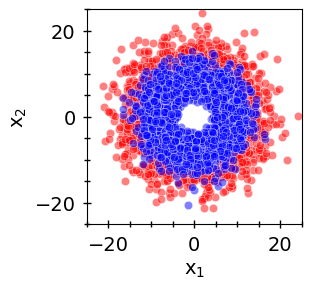

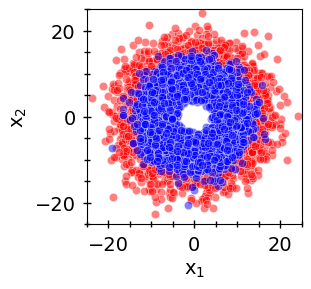

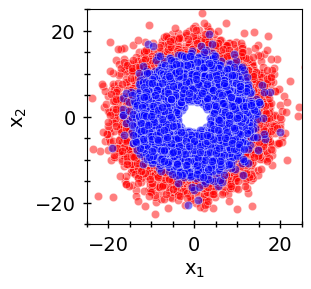

In [8]:
# Plot training data

for i in range(len(n_data)):
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (3, 3), layout="constrained")
    axs = plot_data(train_data[0:n_data[i]], ax, "")
    #fig.savefig(f"../fig/train_data_n_{n_data[i]}.pdf")

## Ensembling

In [9]:

def train_ensemble(n_ensemble, n_data, n_classes):
    if (n_ensemble%n_classes) != 0:
        print("Please set n_ensembles to n_classes*int.")
        return None

    val_data_ensembles = pd.read_csv(f"../data/{valfile}.csv")
    test_data_ensembles = pd.read_csv(f"../data/{testfile}.csv")
    grid_ensembles = pd.DataFrame(columns = ["x1", "x2", "r_x", "a_x"], index = range(100*100))
    biased_class = 0
    # Timer
    start = timer()
    print(f"Starting training of {n_ensemble} ensembles with {n_data} training points.")
    for i in range(n_ensemble):
        print(f"Ensemble nr {i}, N train = {n_data}")
        # Fresh validation dataframe
        val_data = pd.read_csv(f"../data/{valfile}.csv")
        val_data = word_to_int(val_data)

        # Create datasets
        train_dataset = torch.utils.data.TensorDataset(X_train[0:n_data], Y_train[0:n_data])

        # Create new model
        model = SequentialNet(L=1024, n_hidden=3, activation="relu", in_channels=2, out_channels=2).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        # Train model
        training_results = train_classifier(model, train_dataset, 
                                val_dataset, batchsize=2**9, epochs = 70, 
                                device = device, optimizer = optimizer, early_stopping=patience,
                                biased_class=biased_class)
        
        # Predict on validation set
        truth_val, logits_val = predict_classifier(model, val_dataset, 2, 100, device)
        preds_val = torch.argmax(logits_val, dim=-1).flatten()
        val_data_ensembles[f"Prediction_{i}"] = preds_val
        val_data_ensembles["Truth"] = truth_val
        #Get softmax score for blue
        val_data_ensembles[f"Confidence_{i}"] = torch.softmax(logits_val, dim=-1)[:,1]

        # Predict on test set
        truth_test, logits_test = predict_classifier(model, test_dataset, 2, 100, device)
        preds_test = torch.argmax(logits_test, dim=-1).flatten()
        test_data_ensembles[f"Prediction_{i}"] = preds_test
        test_data_ensembles["Truth"] = truth_test
        #Get softmax score for blue
        test_data_ensembles[f"Confidence_{i}"] = torch.softmax(logits_test, dim=-1)[:,1]

        # Predict for grid
        grid_df = predict_grid(model, x1_key, x2_key, device)
        grid_ensembles[f"x1"] = grid_df["x1"]
        grid_ensembles[f"x2"] = grid_df["x2"]
        grid_ensembles[f"r_x"] = grid_df["r_x"]
        grid_ensembles[f"a_x"] = grid_df["a_x"]
        grid_ensembles[f"Confidence_{i}"] = grid_df["Confidence"]
    
        if biased_class < n_classes-1:
            biased_class = biased_class + 1
        else:
            biased_class = 0
    end = timer()
    print("Training time: ", timedelta(seconds=end-start))
    return val_data_ensembles, test_data_ensembles, grid_ensembles

n_ensemble = 10

if load_ensemble_values==False:
    for i in range(len(n_data)):
        logloss_min = 1
        #for j in tqdm(range(20)):
        val_df, test_df, grid_df = train_ensemble(n_ensemble, n_data[i], n_classes=2)
        val_df["Confidence_avg"] = val_df[[f"Confidence_{i}" for i in range(n_ensemble)]].mean(axis=1)
        val_df["Confidence_std"] = val_df[[f"Confidence_{i}" for i in range(n_ensemble)]].std(axis=1)
        val_df["Prediction_ensemble"] = 0
        mask = val_df["Confidence_avg"] > 0.5
        val_df.loc[mask, "Prediction_ensemble"] = 1

        ll = log_loss(val_df["class"], val_df["Confidence_avg"])
        preds = torch.Tensor(val_df["Confidence_avg"])
        target = torch.Tensor(val_df["class"])
        bce_l1 = BinaryCalibrationError(n_bins=15, norm='l1')
        ece = bce_l1(preds, target).item()
        print(f"n_train = {n_data[i]}, logloss={ll}, ECE= {ece}")

        #if ll < logloss_min:
            #print(f"New best values: n_train = {n_data[i]}, logloss={ll}, ECE= {ece}")
            #logloss_min = ll

        val_data_ensembles = val_df
        test_data_ensembles = test_df
        grid_ensembles = grid_df

        test_data_ensembles["Confidence_avg"] = test_data_ensembles[[f"Confidence_{i}" for i in range(n_ensemble)]].mean(axis=1)
        test_data_ensembles["Confidence_std"] = test_data_ensembles[[f"Confidence_{i}" for i in range(n_ensemble)]].std(axis=1)
        test_data_ensembles["Prediction_ensemble"] = 0
        mask = test_data_ensembles["Confidence_avg"] > 0.5
        test_data_ensembles.loc[mask, "Prediction_ensemble"] = 1

        grid_ensembles["Confidence_avg"] = grid_ensembles[[f"Confidence_{i}" for i in range(n_ensemble)]].mean(axis=1)
        grid_ensembles["Confidence_std"] = grid_ensembles[[f"Confidence_{i}" for i in range(n_ensemble)]].std(axis=1)
        # Save best prediction
        if save_values:
            if (not os.path.isdir(f"predictions/{trainfile}") ):
                os.mkdir(f"predictions/{trainfile}")
            val_data_ensembles.to_csv(f"predictions/{trainfile}/{valfile}_predicted_SequentialNet_CL_{n_ensemble}ensembles_ndata-{n_data[i]}.csv")
            test_data_ensembles.to_csv(f"predictions/{trainfile}/{testfile}_predicted_SequentialNet_CL_{n_ensemble}ensembles_ndata-{n_data[i]}.csv")
            grid_ensembles.to_csv(f"predictions/{trainfile}/grid_{tag}_predicted_SequentialNet_CL_{n_ensemble}ensembles_ndata-{n_data[i]}.csv")

    val_data_ensembles = [pd.read_csv(f"predictions/{trainfile}/{valfile}_predicted_SequentialNet_CL_{n_ensemble}ensembles_ndata-{n_data[i]}.csv") for i in range(len(n_data))]
    test_data_ensembles = [pd.read_csv(f"predictions/{trainfile}/{testfile}_predicted_SequentialNet_CL_{n_ensemble}ensembles_ndata-{n_data[i]}.csv") for i in range(len(n_data))]
    grid_ensembles = [pd.read_csv(f"predictions/{trainfile}/grid_{tag}_predicted_SequentialNet_CL_{n_ensemble}ensembles_ndata-{n_data[i]}.csv") for i in range(len(n_data))]

else:
    val_data_ensembles = [pd.read_csv(f"predictions/{trainfile}/{valfile}_predicted_SequentialNet_CL_{n_ensemble}ensembles_ndata-{n_data[i]}.csv") for i in range(len(n_data))]
    test_data_ensembles = [pd.read_csv(f"predictions/{trainfile}/{testfile}_predicted_SequentialNet_CL_{n_ensemble}ensembles_ndata-{n_data[i]}.csv") for i in range(len(n_data))]
    grid_ensembles = [pd.read_csv(f"predictions/{trainfile}/grid_{tag}_predicted_SequentialNet_CL_{n_ensemble}ensembles_ndata-{n_data[i]}.csv") for i in range(len(n_data))]


Starting training of 10 ensembles with 250 training points.
Ensemble nr 0, N train = 250


100%|██████████| 100/100 [00:00<00:00, 530.73it/s]


Ensemble nr 1, N train = 250


100%|██████████| 100/100 [00:00<00:00, 530.01it/s]


Ensemble nr 2, N train = 250


100%|██████████| 100/100 [00:00<00:00, 531.11it/s]


Ensemble nr 3, N train = 250


100%|██████████| 100/100 [00:00<00:00, 537.95it/s]


Ensemble nr 4, N train = 250


100%|██████████| 100/100 [00:00<00:00, 536.33it/s]


Ensemble nr 5, N train = 250


100%|██████████| 100/100 [00:00<00:00, 535.31it/s]


Ensemble nr 6, N train = 250


100%|██████████| 100/100 [00:00<00:00, 535.02it/s]


Ensemble nr 7, N train = 250


100%|██████████| 100/100 [00:00<00:00, 534.90it/s]


Ensemble nr 8, N train = 250


100%|██████████| 100/100 [00:00<00:00, 533.21it/s]


Ensemble nr 9, N train = 250


100%|██████████| 100/100 [00:00<00:00, 530.50it/s]


Training time:  0:01:03.433219
n_train = 250, logloss=0.5966366419924949, ECE= 0.05202220007777214
Starting training of 10 ensembles with 500 training points.
Ensemble nr 0, N train = 500


100%|██████████| 100/100 [00:00<00:00, 532.99it/s]


Ensemble nr 1, N train = 500


100%|██████████| 100/100 [00:00<00:00, 531.76it/s]


Ensemble nr 2, N train = 500


100%|██████████| 100/100 [00:00<00:00, 534.07it/s]


Ensemble nr 3, N train = 500


100%|██████████| 100/100 [00:00<00:00, 533.17it/s]


Ensemble nr 4, N train = 500


100%|██████████| 100/100 [00:00<00:00, 528.64it/s]


Ensemble nr 5, N train = 500


100%|██████████| 100/100 [00:00<00:00, 531.69it/s]


Ensemble nr 6, N train = 500


100%|██████████| 100/100 [00:00<00:00, 529.02it/s]


Ensemble nr 7, N train = 500


100%|██████████| 100/100 [00:00<00:00, 530.18it/s]


Ensemble nr 8, N train = 500


100%|██████████| 100/100 [00:00<00:00, 533.30it/s]


Ensemble nr 9, N train = 500


100%|██████████| 100/100 [00:00<00:00, 532.96it/s]


Training time:  0:01:50.036837
n_train = 500, logloss=0.5752875007160809, ECE= 0.09707880765199661
Starting training of 10 ensembles with 1000 training points.
Ensemble nr 0, N train = 1000


100%|██████████| 100/100 [00:00<00:00, 532.11it/s]


Ensemble nr 1, N train = 1000


100%|██████████| 100/100 [00:00<00:00, 529.67it/s]


Ensemble nr 2, N train = 1000


100%|██████████| 100/100 [00:00<00:00, 533.97it/s]


Ensemble nr 3, N train = 1000


100%|██████████| 100/100 [00:00<00:00, 526.06it/s]


Ensemble nr 4, N train = 1000


100%|██████████| 100/100 [00:00<00:00, 528.22it/s]


Ensemble nr 5, N train = 1000


100%|██████████| 100/100 [00:00<00:00, 534.10it/s]


Ensemble nr 6, N train = 1000


100%|██████████| 100/100 [00:00<00:00, 531.21it/s]


Ensemble nr 7, N train = 1000


100%|██████████| 100/100 [00:00<00:00, 534.50it/s]


Ensemble nr 8, N train = 1000


100%|██████████| 100/100 [00:00<00:00, 532.57it/s]


Ensemble nr 9, N train = 1000


100%|██████████| 100/100 [00:00<00:00, 533.79it/s]


Training time:  0:03:34.812041
n_train = 1000, logloss=0.5334639797246246, ECE= 0.052618999034166336
Starting training of 10 ensembles with 2000 training points.
Ensemble nr 0, N train = 2000


100%|██████████| 100/100 [00:00<00:00, 531.49it/s]


Ensemble nr 1, N train = 2000


100%|██████████| 100/100 [00:00<00:00, 529.68it/s]


Ensemble nr 2, N train = 2000


100%|██████████| 100/100 [00:00<00:00, 531.39it/s]


Ensemble nr 3, N train = 2000


100%|██████████| 100/100 [00:00<00:00, 522.86it/s]


Ensemble nr 4, N train = 2000


100%|██████████| 100/100 [00:00<00:00, 530.34it/s]


Ensemble nr 5, N train = 2000


100%|██████████| 100/100 [00:00<00:00, 531.56it/s]


Ensemble nr 6, N train = 2000


100%|██████████| 100/100 [00:00<00:00, 476.28it/s]


Ensemble nr 7, N train = 2000


100%|██████████| 100/100 [00:00<00:00, 517.52it/s]


Ensemble nr 8, N train = 2000


100%|██████████| 100/100 [00:00<00:00, 512.16it/s]


Ensemble nr 9, N train = 2000


100%|██████████| 100/100 [00:00<00:00, 478.69it/s]


Training time:  0:07:53.774627
n_train = 2000, logloss=0.531564172957458, ECE= 0.046023767441511154
Starting training of 10 ensembles with 3000 training points.
Ensemble nr 0, N train = 3000


100%|██████████| 100/100 [00:00<00:00, 530.04it/s]


Ensemble nr 1, N train = 3000


100%|██████████| 100/100 [00:00<00:00, 514.18it/s]


Ensemble nr 2, N train = 3000


100%|██████████| 100/100 [00:00<00:00, 524.34it/s]


Ensemble nr 3, N train = 3000


100%|██████████| 100/100 [00:00<00:00, 479.92it/s]


Ensemble nr 4, N train = 3000


100%|██████████| 100/100 [00:00<00:00, 487.45it/s]


Ensemble nr 5, N train = 3000


100%|██████████| 100/100 [00:00<00:00, 534.98it/s]


Ensemble nr 6, N train = 3000


100%|██████████| 100/100 [00:00<00:00, 475.09it/s]


Ensemble nr 7, N train = 3000


100%|██████████| 100/100 [00:00<00:00, 533.33it/s]


Ensemble nr 8, N train = 3000


100%|██████████| 100/100 [00:00<00:00, 535.38it/s]


Ensemble nr 9, N train = 3000


100%|██████████| 100/100 [00:00<00:00, 531.92it/s]


Training time:  0:12:09.979281
n_train = 3000, logloss=0.5277900778482515, ECE= 0.04454013705253601
Starting training of 10 ensembles with 5000 training points.
Ensemble nr 0, N train = 5000


100%|██████████| 100/100 [00:00<00:00, 531.90it/s]


Ensemble nr 1, N train = 5000


100%|██████████| 100/100 [00:00<00:00, 531.56it/s]


Ensemble nr 2, N train = 5000


100%|██████████| 100/100 [00:00<00:00, 531.62it/s]


Ensemble nr 3, N train = 5000


100%|██████████| 100/100 [00:00<00:00, 531.36it/s]


Ensemble nr 4, N train = 5000


100%|██████████| 100/100 [00:00<00:00, 532.62it/s]


Ensemble nr 5, N train = 5000


100%|██████████| 100/100 [00:00<00:00, 529.71it/s]


Ensemble nr 6, N train = 5000


100%|██████████| 100/100 [00:00<00:00, 532.24it/s]


Ensemble nr 7, N train = 5000


100%|██████████| 100/100 [00:00<00:00, 531.44it/s]


Ensemble nr 8, N train = 5000


100%|██████████| 100/100 [00:00<00:00, 529.89it/s]


Ensemble nr 9, N train = 5000


100%|██████████| 100/100 [00:00<00:00, 533.18it/s]


Training time:  0:17:12.162822
n_train = 5000, logloss=0.5214063585193052, ECE= 0.03405549377202988
Starting training of 10 ensembles with 10000 training points.
Ensemble nr 0, N train = 10000


100%|██████████| 100/100 [00:00<00:00, 533.15it/s]


Ensemble nr 1, N train = 10000


100%|██████████| 100/100 [00:00<00:00, 531.97it/s]


Ensemble nr 2, N train = 10000


100%|██████████| 100/100 [00:00<00:00, 530.39it/s]


Ensemble nr 3, N train = 10000


100%|██████████| 100/100 [00:00<00:00, 535.30it/s]


Ensemble nr 4, N train = 10000


100%|██████████| 100/100 [00:00<00:00, 535.28it/s]


Ensemble nr 5, N train = 10000


100%|██████████| 100/100 [00:00<00:00, 529.55it/s]


Ensemble nr 6, N train = 10000


100%|██████████| 100/100 [00:00<00:00, 533.04it/s]


Ensemble nr 7, N train = 10000


100%|██████████| 100/100 [00:00<00:00, 535.60it/s]


Ensemble nr 8, N train = 10000


100%|██████████| 100/100 [00:00<00:00, 536.29it/s]


Ensemble nr 9, N train = 10000


100%|██████████| 100/100 [00:00<00:00, 532.44it/s]


Training time:  0:34:10.447289
n_train = 10000, logloss=0.5196590105076827, ECE= 0.02751952037215233


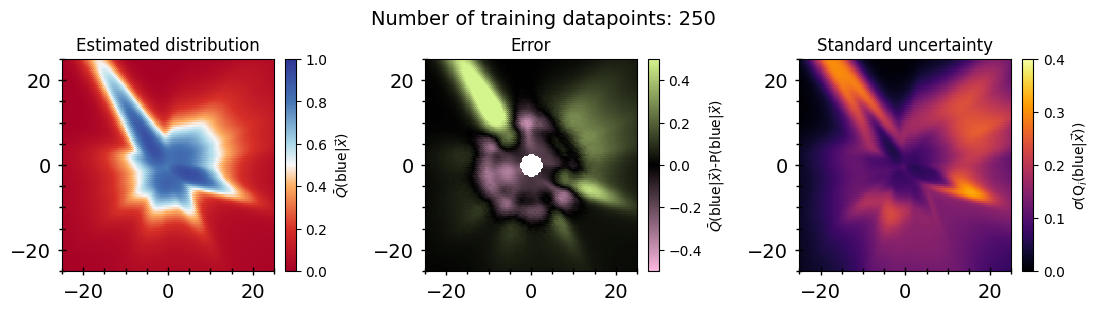

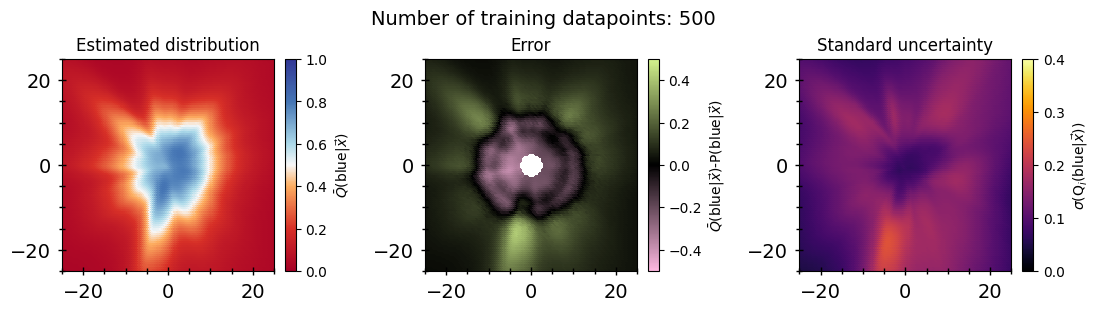

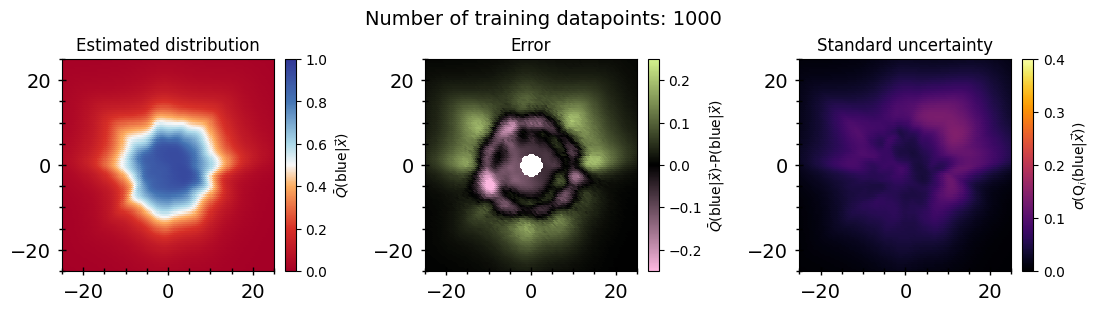

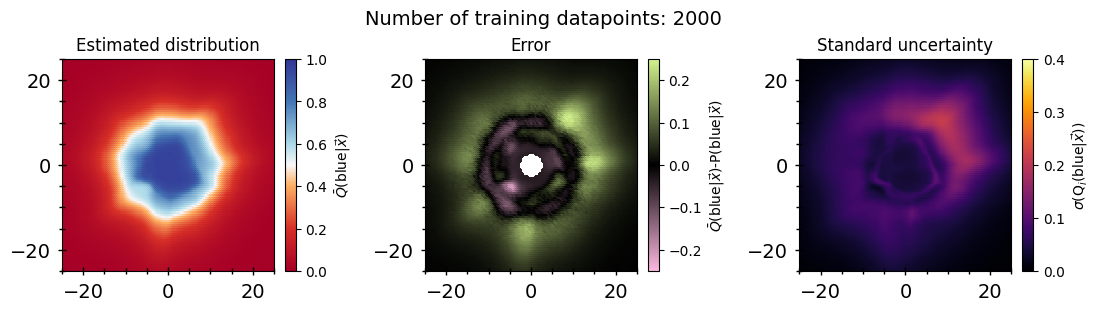

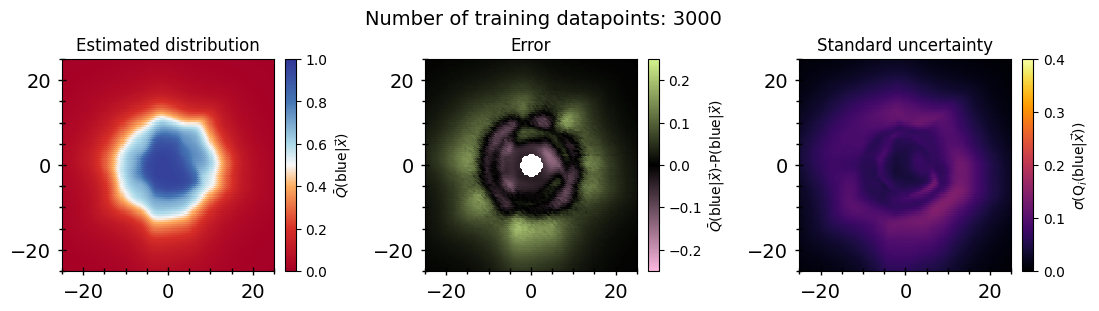

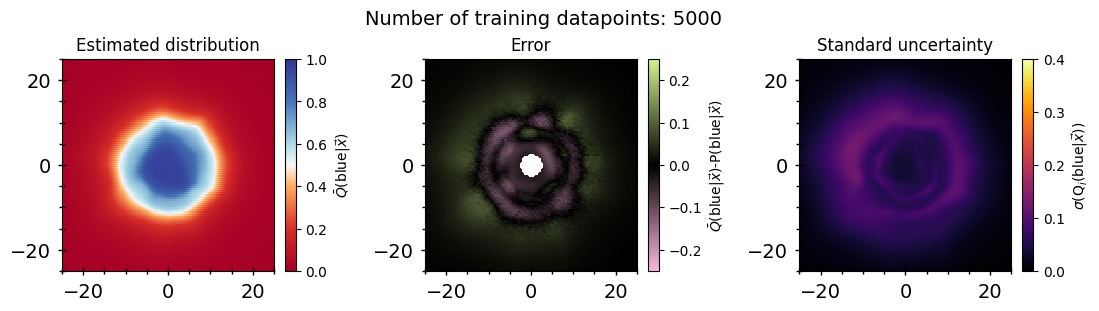

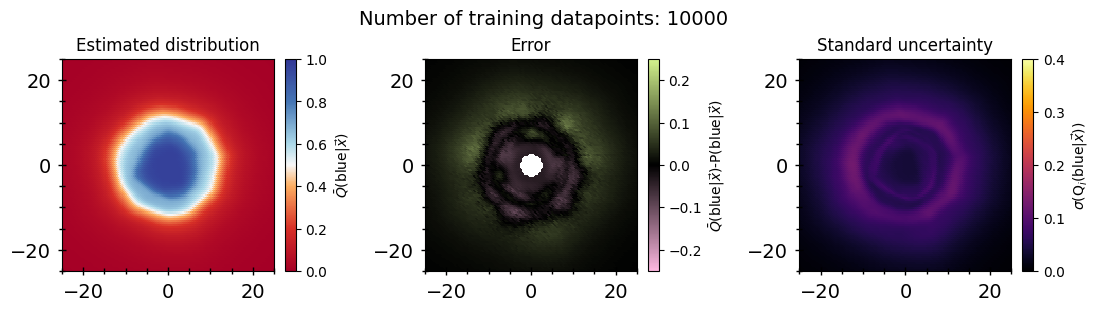

In [10]:
for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (11,3), layout="constrained")
    axs[0] = plot_results(grid_ensembles[i], "Confidence_avg", axs[0], "Estimated distribution", grid=True)
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=red_blue_cmap()), fraction=0.050, pad=0.04, label=r"$\bar{Q}$(blue|$\vec{x}$)", ax=axs[0])

    axs[1] = plot_diff(grid_ensembles[i], truth_data, "Confidence_avg", "P_blue_given_x", axs[1], r"Error", max_val = max_err_val[i])
    hue_norm = mpl.colors.Normalize(vmin=-max_err_val[i], vmax=max_err_val[i], clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=pink_black_green_cmap()), 
                 fraction=0.050, pad=0.04, label=r"$\bar{Q}$(blue|$\vec{x}$)-P(blue|$\vec{x}$)", ax=axs[1])

    axs[2] = plot_std(grid_ensembles[i], "Confidence_std", axs[2], "Standard uncertainty", grid=True, max_val = 0.4)
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=0.4, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap="inferno"), fraction=0.050, pad=0.04, label=r"$\sigma$(Q$_i$(blue|$\vec{x}$))", ax=axs[2])

    fig.suptitle(f"Number of training datapoints: {n_data[i]}", fontsize=14)
    #fig.savefig(f"../fig/DNN_ensemble_ntrain_{n_data[i]}.pdf", format="pdf", bbox_inches='tight', dpi=350)

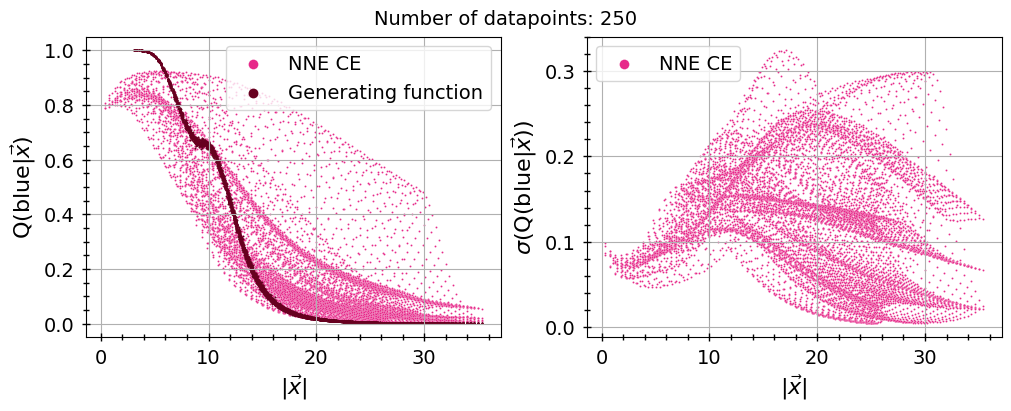

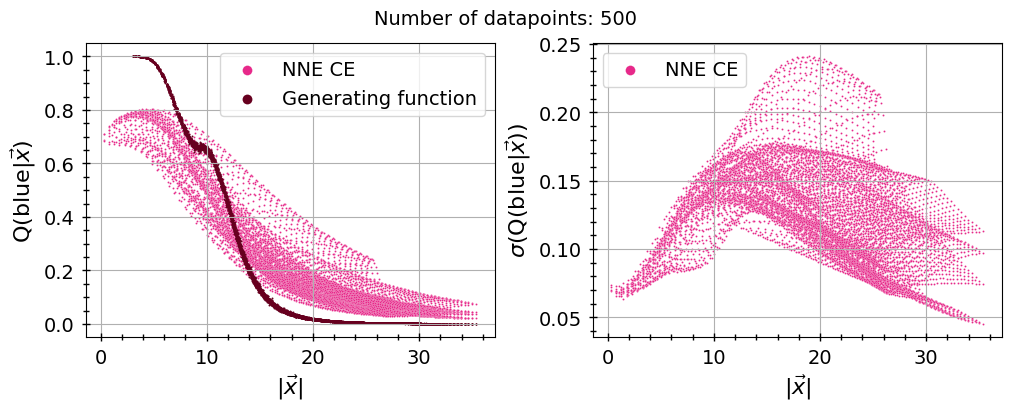

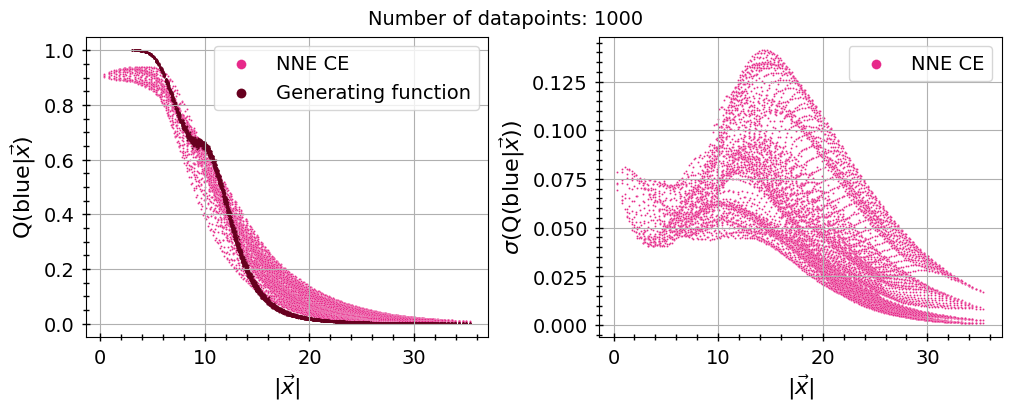

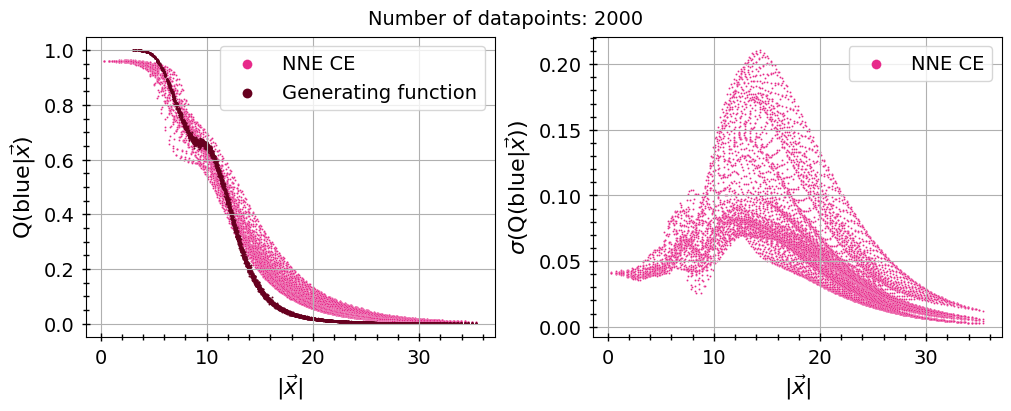

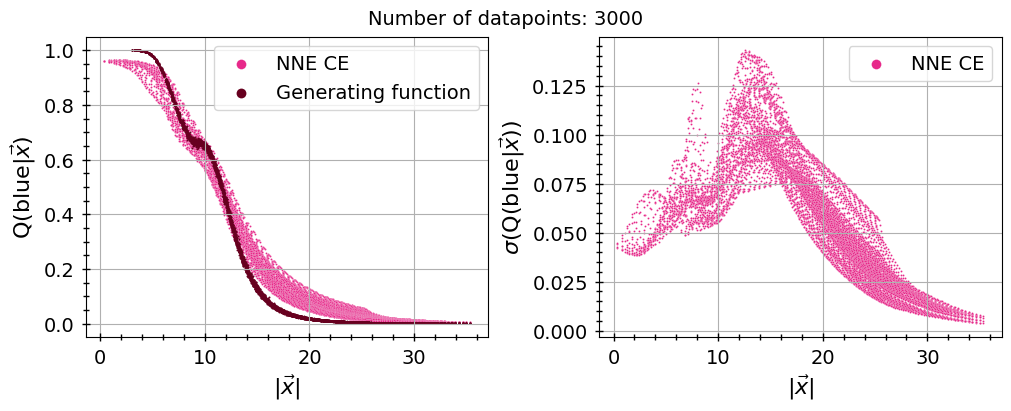

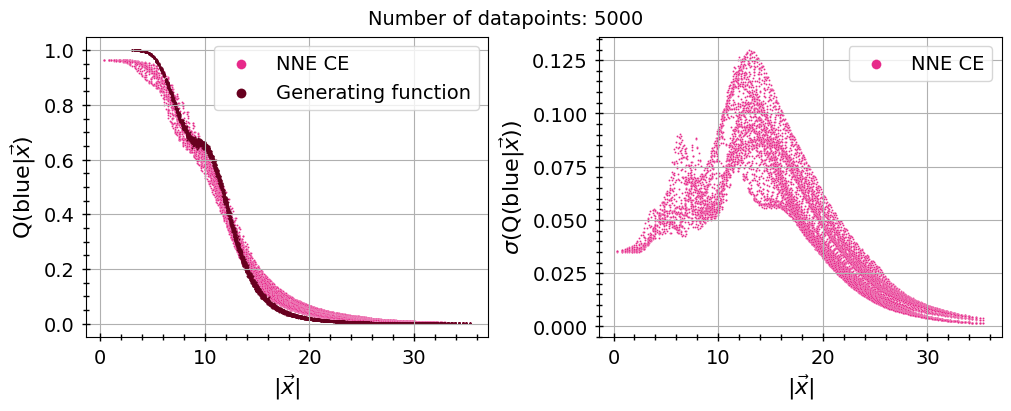

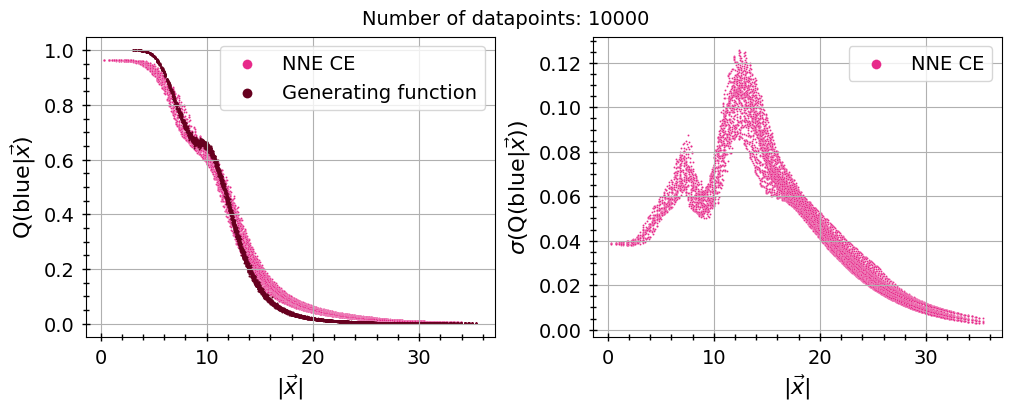

In [11]:

for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
    sn.scatterplot(grid_ensembles[i], x="r_x", y="Confidence_avg", s=2, ax = axs[0], label="NNE CE", color="#e7298a")
    #sn.lineplot(truth_data, x="r_x", y="P_blue_given_x", linewidth=2, ax = axs[0], label="Generating function", color="#67001f")
    sn.scatterplot(truth_data, x="r_x", y="P_blue_given_x", s=2, ax = axs[0], label="Generating function", color="#67001f", linewidth=0)
    axs[0].set_ylabel(r"Q(blue|$\vec{x}$)", fontsize=16)

    sn.scatterplot(grid_ensembles[i], x="r_x", y="Confidence_std", s=2, ax = axs[1], label="NNE CE", color="#e7298a")
    axs[1].set_ylabel(r"$\sigma$(Q(blue|$\vec{x}$))", fontsize=16)
    #axs[1].set_ylim(0, 0.3)

    for ax in axs:
        ax.legend(markerscale=5, fontsize=14)
        ax.set_xlabel(r"$|\vec{x}|$", fontsize=16)
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
        ax.minorticks_on()
        ax.grid()
    fig.suptitle(f"Number of datapoints: {n_data[i]}", fontsize=14)

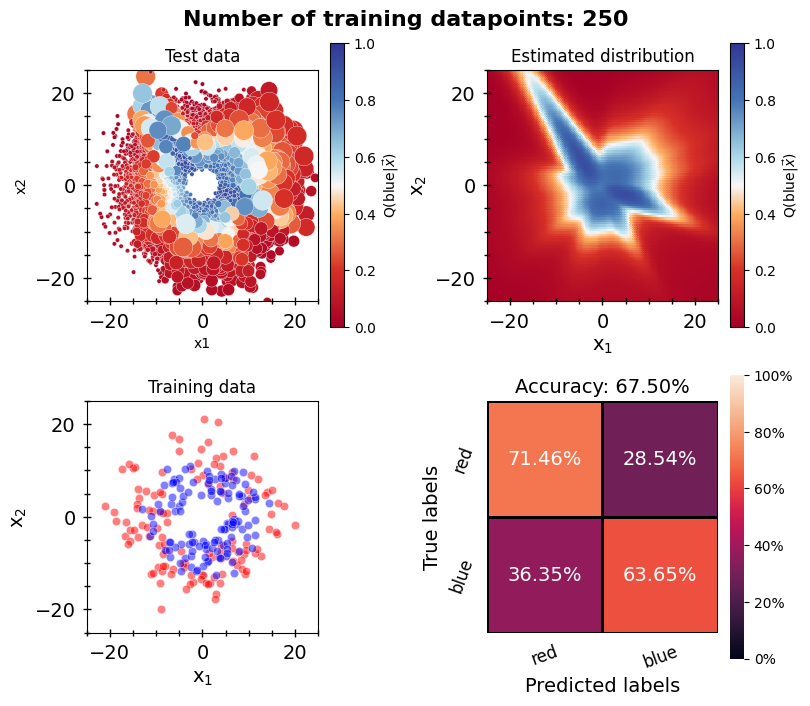

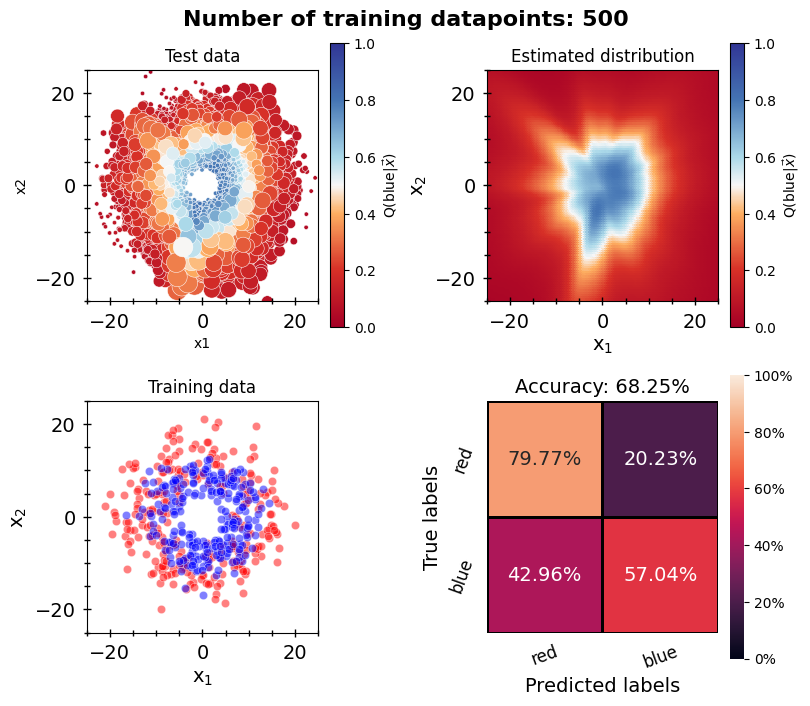

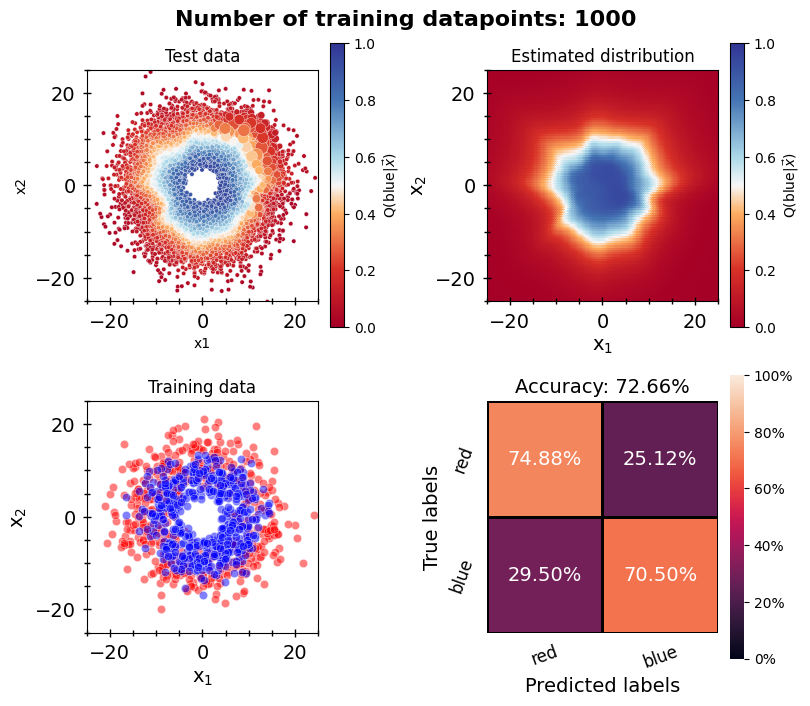

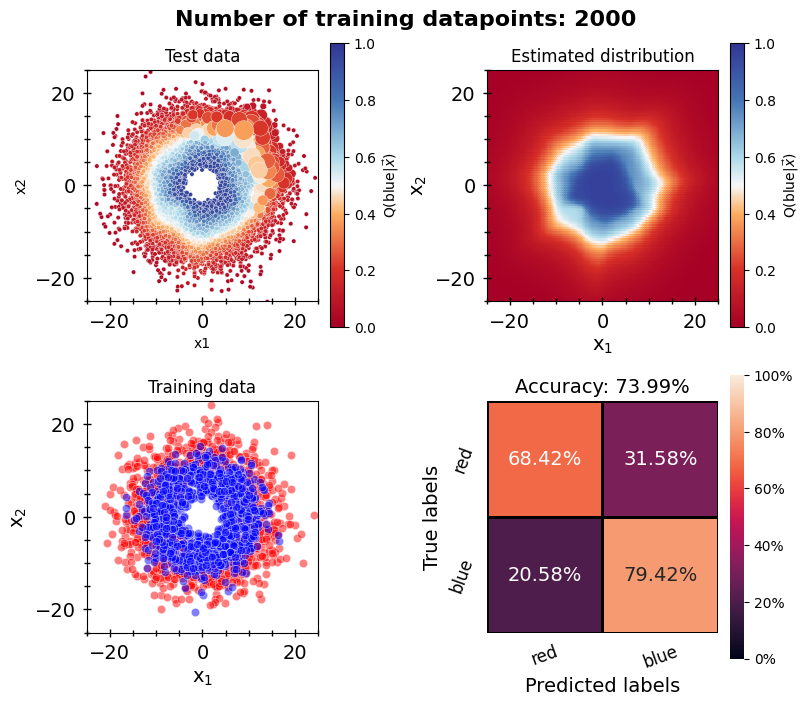

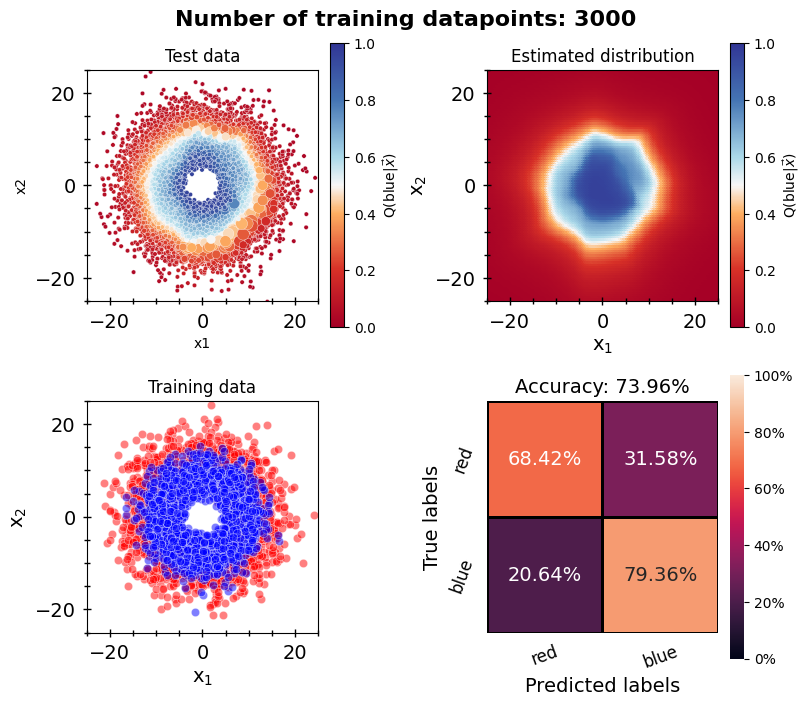

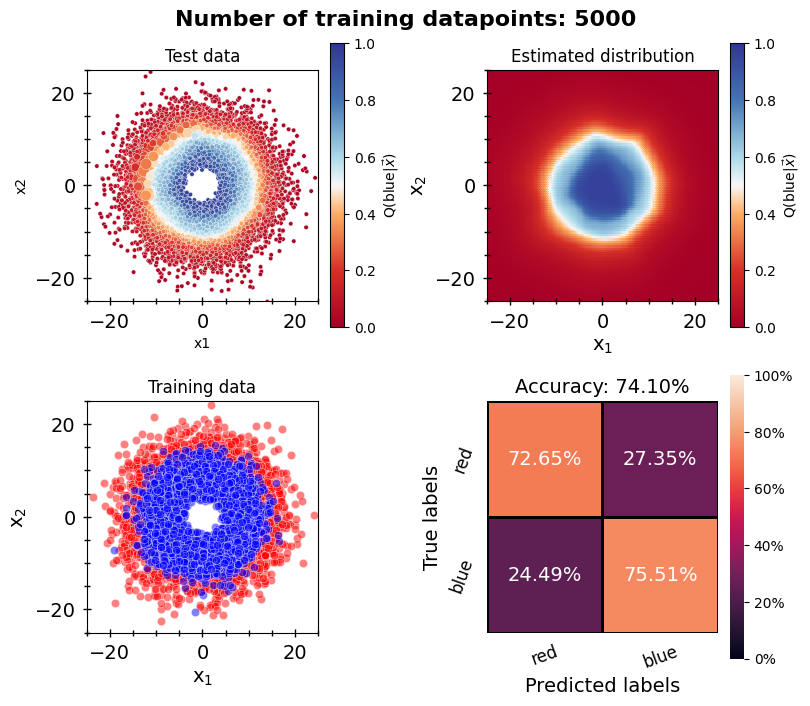

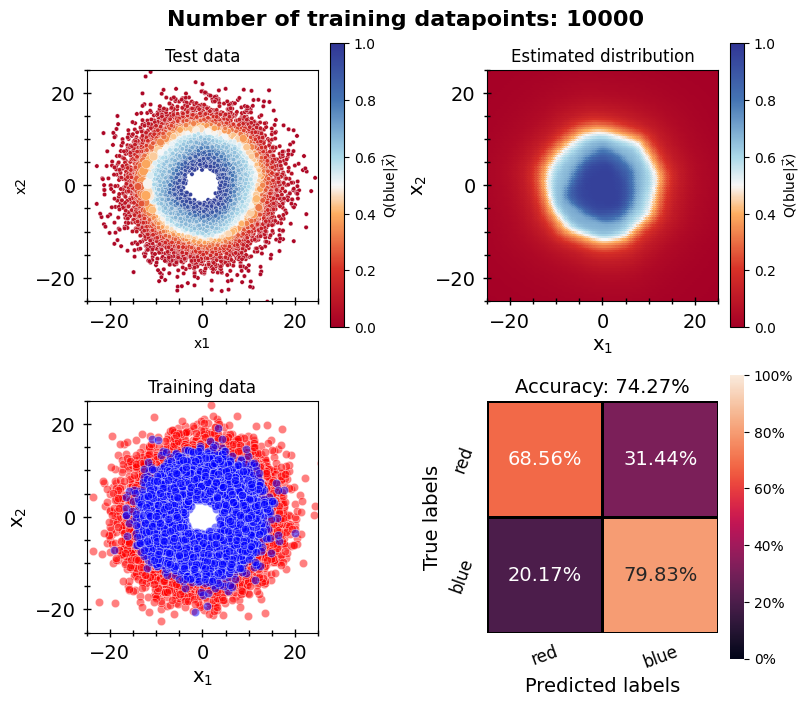

In [12]:
for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")
    
    axs[0][0] = plot_results(test_data_ensembles[i], "Confidence_avg", axs[0][0], "Test data", "Confidence_std")
    axs[0][1] = plot_grid(grid_ensembles[i], "Confidence_avg", axs[0][1], "Estimated distribution")
    axs[1][1] = plot_conf_matrix(test_data_ensembles[i], "class", "Prediction_ensemble", ["red", "blue"], axs[1][1])
    axs[1][0] = plot_data(train_data[0:n_data[i]], axs[1][0], "Training data")

    cmap = red_blue_cmap()
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][0])
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][1])

    fig.suptitle(f"Number of training datapoints: {n_data[i]}", size=16, fontweight="bold")


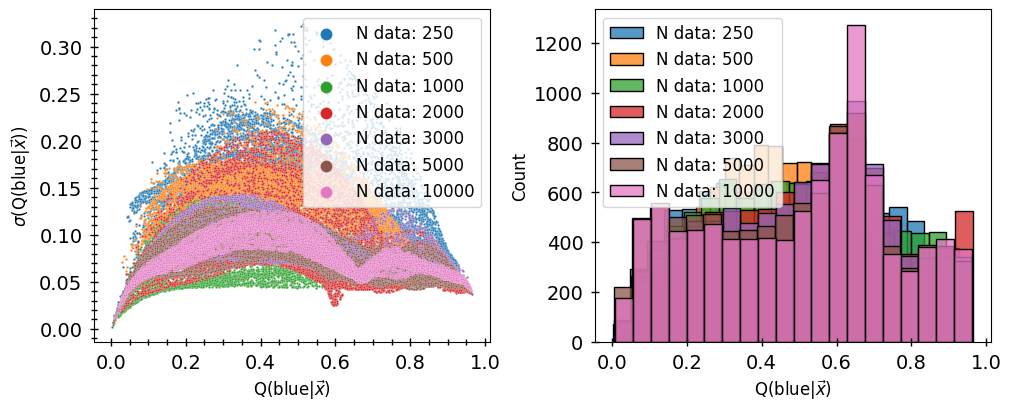

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
for i in range(len(n_data)):
    sn.scatterplot(test_data_ensembles[i], x="Confidence_avg", y="Confidence_std", s=3, label=f"N data: {n_data[i]}", ax = axs[0])
    axs[0].legend(markerscale=5, fontsize=12)
    axs[0].set_ylabel(r"$\sigma$(Q(blue|$\vec{x}$))", fontsize=12)
    axs[0].set_xlabel(r"Q(blue|$\vec{x}$)", fontsize=12)
    #axs[0].set_ylim(0, 0.25)
    sn.histplot(test_data_ensembles[i], x="Confidence_avg", label=f"N data: {n_data[i]}", ax = axs[1], bins=20, edgecolor="black", linewidth=1)
    axs[1].legend(markerscale=5, fontsize=12)
    axs[1].set_ylabel("Count", fontsize=12)
    axs[1].set_xlabel(r"Q(blue|$\vec{x}$)", fontsize=12)
    for ax in axs:
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
    axs[0].minorticks_on()
    #fig.suptitle(f"Number of training datapoints: {n_data[i]}", size=16, fontweight="bold")

In [14]:
scores = calculate_metrics(test_data_ensembles, grid_ensembles, n_data, truth_data, truth_test_data, 
                           "Prediction_ensemble", "Confidence_avg", "Confidence_std")
scores.to_csv(f"predictions/{trainfile}/NNEscores.csv")
print(scores)

   N data       ACC    ROCAUC   WD test   WD grid    Avg UE    Std UE  \
0     250  0.674967  0.748679  0.056839  0.077753  0.143727  0.045458   
1     500  0.682468  0.784278  0.116348  0.103644  0.139010  0.024908   
2    1000  0.726573  0.812329  0.054599  0.047132  0.072146  0.024053   
3    2000  0.739874  0.814468  0.045737  0.051549  0.086306  0.038688   
4    3000  0.739574  0.817656  0.044812  0.045916  0.082853  0.021555   
5    5000  0.740974  0.819953  0.035069  0.023691  0.075069  0.021272   
6   10000  0.742674  0.820649  0.027306  0.029762  0.075796  0.019643   

   Mean KL-div test  Mean KL-div grid   LogLoss       ECE       MCE     RMSCE  
0          0.047837          0.061604  0.595306  0.050478  0.114655  0.061948  
1          0.038281          0.060378  0.580068  0.093151  0.156549  0.101067  
2          0.020704          0.019979  0.531475  0.051285  0.094170  0.057861  
3          0.019605          0.021024  0.528138  0.045055  0.115709  0.057359  
4          0.01

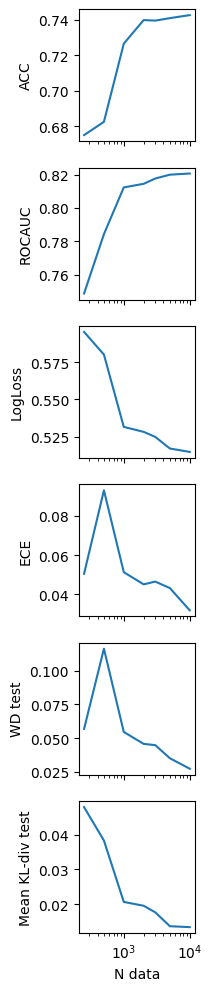

In [15]:
fig, axs = plt.subplots(nrows=6, ncols=1, figsize=(1.5, 12), sharex=True)
sn.lineplot(scores, x="N data", y="ACC", ax=axs[0])
sn.lineplot(scores, x="N data", y="ROCAUC", ax=axs[1])
sn.lineplot(scores, x="N data", y="LogLoss", ax=axs[2])
sn.lineplot(scores, x="N data", y="ECE", ax=axs[3])
sn.lineplot(scores, x="N data", y="WD test", ax=axs[4])
sn.lineplot(scores, x="N data", y="Mean KL-div test", ax=axs[5])
for ax in axs:
    ax.set_xscale("log")

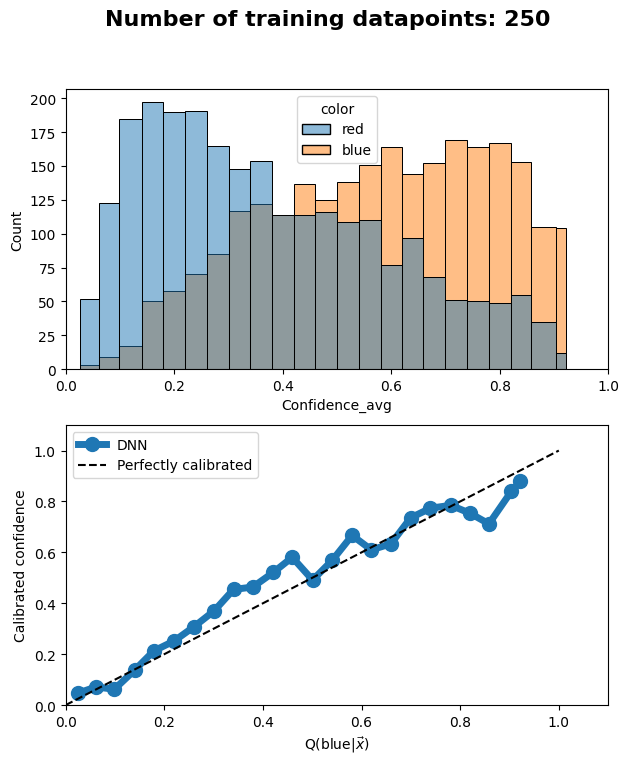

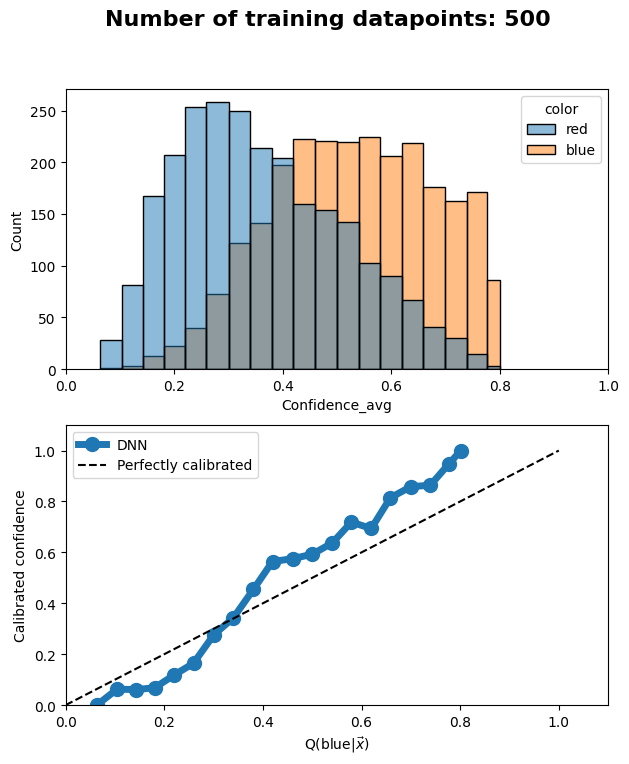

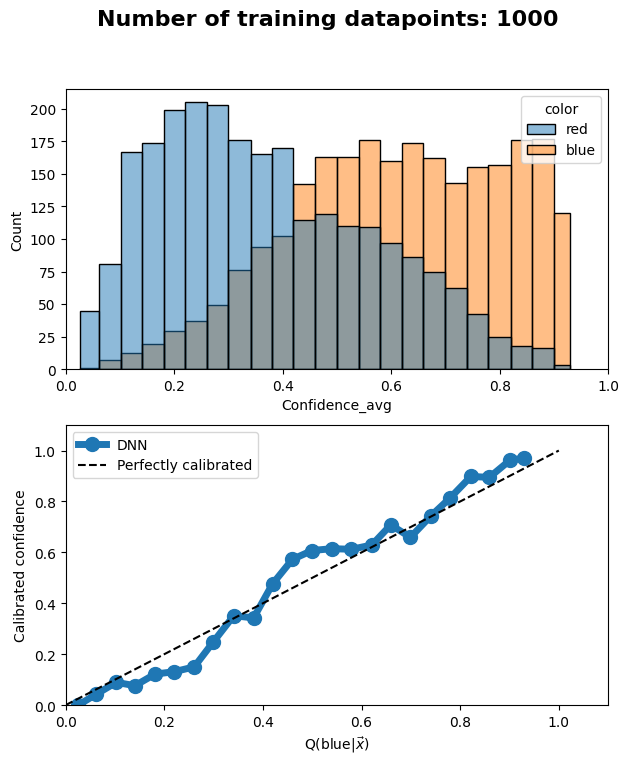

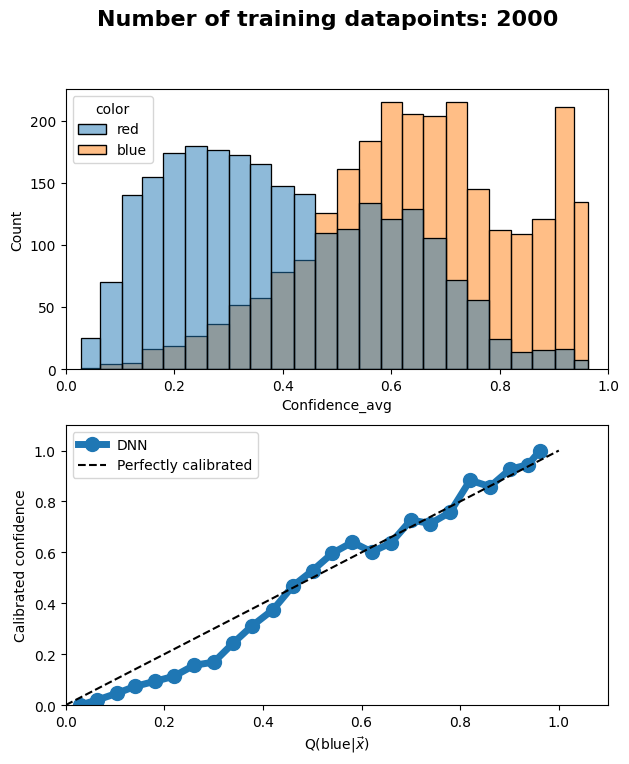

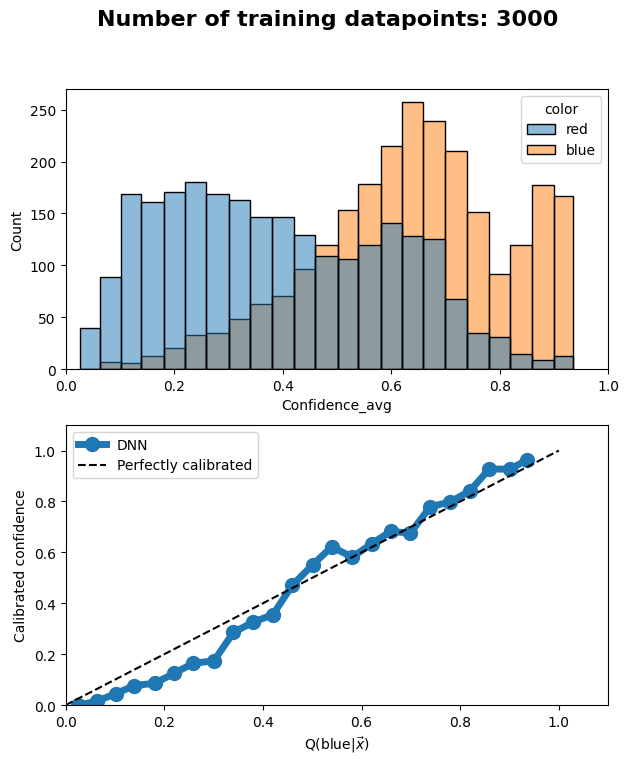

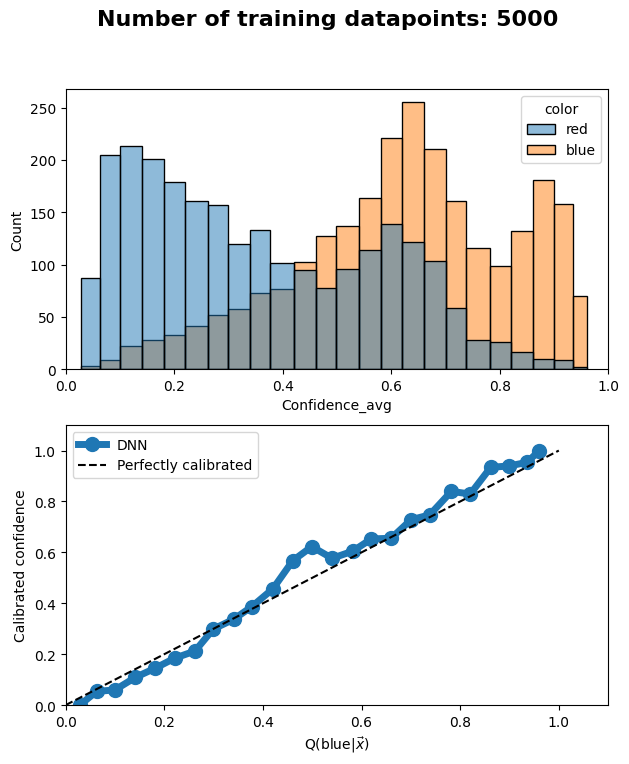

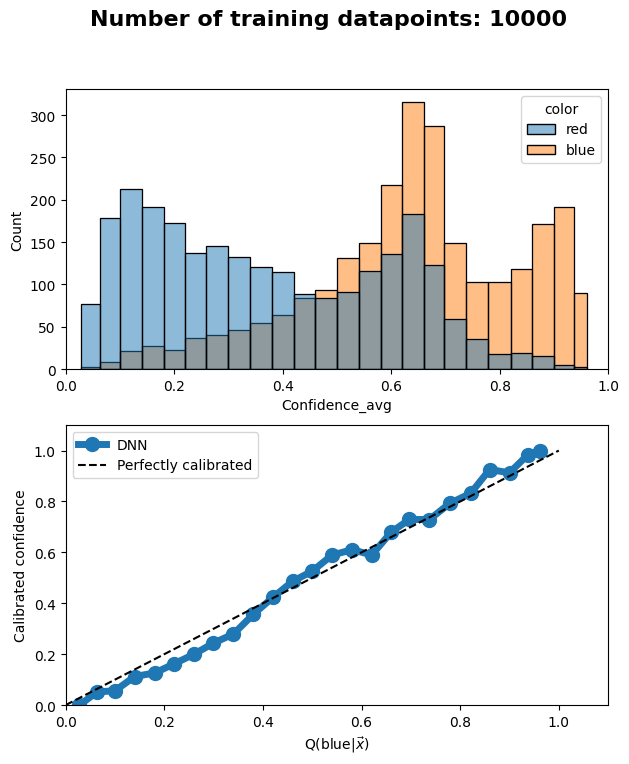

In [16]:


#Get confidence for red
for i in range(len(n_data)):
    df = val_data_ensembles[i]
    prob_cal, prob_pred = calibration_curve(df["Truth"], df["Confidence_avg"], n_bins=25, strategy="uniform")
    pred_bins=list(prob_pred)

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 8))
    sn.histplot(val_data_ensembles[i], x="Confidence_avg", hue="color", ax=ax[0], stat="count", bins=pred_bins)
    ax[0].set_xlim(0,1)
    ax[1].plot(prob_pred, prob_cal, linewidth=5, markersize=10, marker="o", label ="DNN")
    ax[1].set_xlim(0,1.1)
    ax[1].set_ylim(0,1.1)
    x = np.linspace(0, 1, 10)
    ax[1].plot(x, x, color="black", linestyle="--", label="Perfectly calibrated")
    ax[1].set_xlabel(r"Q(blue|$\vec{x}$)")
    ax[1].set_ylabel("Calibrated confidence")
    ax[1].legend()
    fig.suptitle(f"Number of training datapoints: {n_data[i]}", size=16, fontweight="bold")